#### Here is my Understanding of data and steps i want to perform
- **`Null Analysis`**: Understand missing data and decide on handling it.
- **`Distribution Visualization`**: Use the provided histogram code to explore numerical columns.
- **`Correlation Matrix`**: Dive into relationships between features to gain insights.

### EDA, Data Visualization and Feature engineering


In [1]:
import numpy as np
import pandas as pd 
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import copy
import optuna
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from catboost import CatBoostClassifier, Pool
from tqdm import tqdm

/home/codespace/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
submission = pd.read_csv("../data/sample_submission.csv")

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

In [7]:
numerical_col = train.select_dtypes(include= ['number']).columns.to_list()
catagorical_col = train.select_dtypes(include= ['category','object']).columns.to_list()
print(numerical_col)
print(catagorical_col)

['id', 'Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress', 'Depression']
['Name', 'Gender', 'City', 'Working Professional or Student', 'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']


#### Exploring Numerical features

In [8]:

train[numerical_col].isna().sum()

id                         0
Age                        0
Academic Pressure     112803
Work Pressure          27918
CGPA                  112802
Study Satisfaction    112803
Job Satisfaction       27910
Work/Study Hours           0
Financial Stress           4
Depression                 0
dtype: int64

#### Checking for null counts across all columns

                                   Column  Null Count  Null Percentage
10                     Study Satisfaction      112803        80.172708
7                       Academic Pressure      112803        80.172708
9                                    CGPA      112802        80.171997
6                              Profession       36630        26.034115
8                           Work Pressure       27918        19.842217
11                       Job Satisfaction       27910        19.836532
13                         Dietary Habits           4         0.002843
17                       Financial Stress           4         0.002843
14                                 Degree           2         0.001421
18       Family History of Mental Illness           0         0.000000
16                       Work/Study Hours           0         0.000000
15  Have you ever had suicidal thoughts ?           0         0.000000
0                                      id           0         0.000000
12    

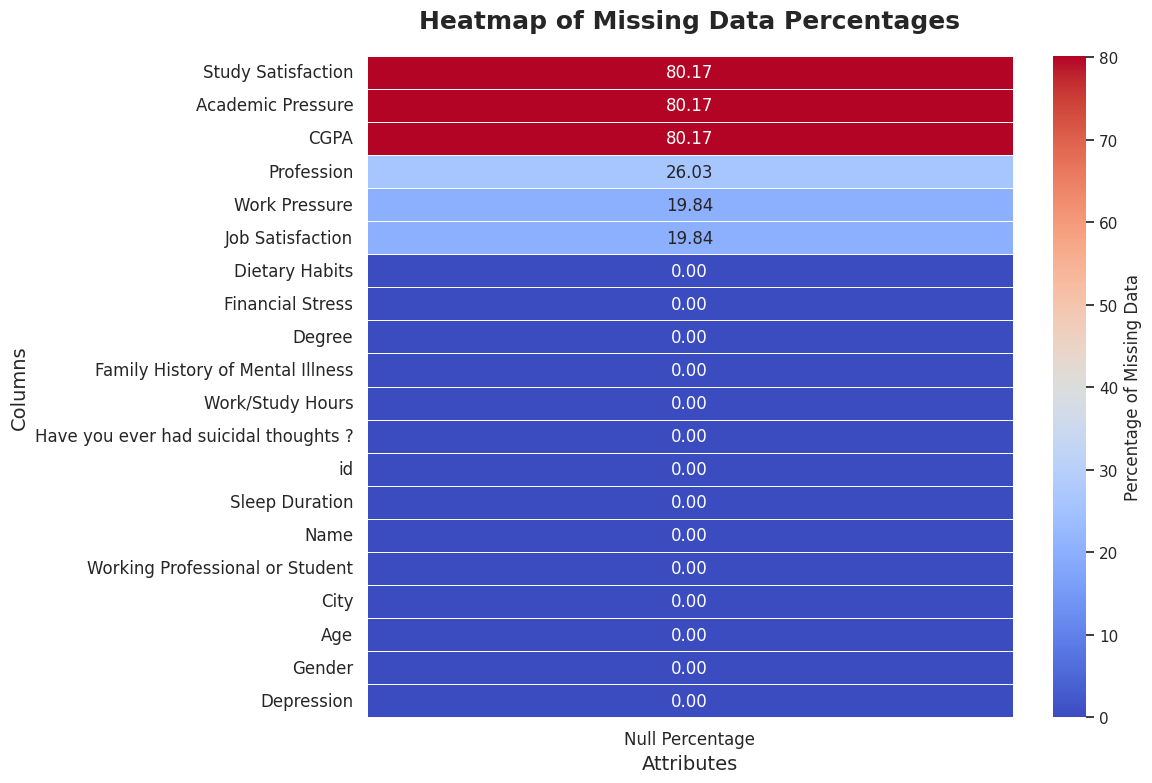

In [22]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


null_counts = train.isna().sum()
null_percentage = (null_counts / len(train)) * 100

# Create a DataFrame for null analysis
null_analysis = pd.DataFrame({
    'Column': null_counts.index,
    'Null Count': null_counts.values,
    'Null Percentage': null_percentage.values
}).sort_values(by='Null Percentage', ascending=False)


output_dir = "../data/analysis"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "null_analysis.csv")
null_analysis.to_csv(output_file, index=False)

print(null_analysis)

# Generate a heatmap for null percentages
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    null_analysis[['Null Percentage']].set_index(null_analysis['Column']),
    annot=True,  
    fmt=".2f",  
    cmap="coolwarm", 
    cbar_kws={"label": "Percentage of Missing Data"},
    linewidths=0.5,
    linecolor='white'
)

plt.title("Heatmap of Missing Data Percentages", fontsize=18, fontweight="bold", pad=20)
plt.xlabel("Attributes", fontsize=14)
plt.ylabel("Columns", fontsize=14)

plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()

plt.show()


#### Null analysis

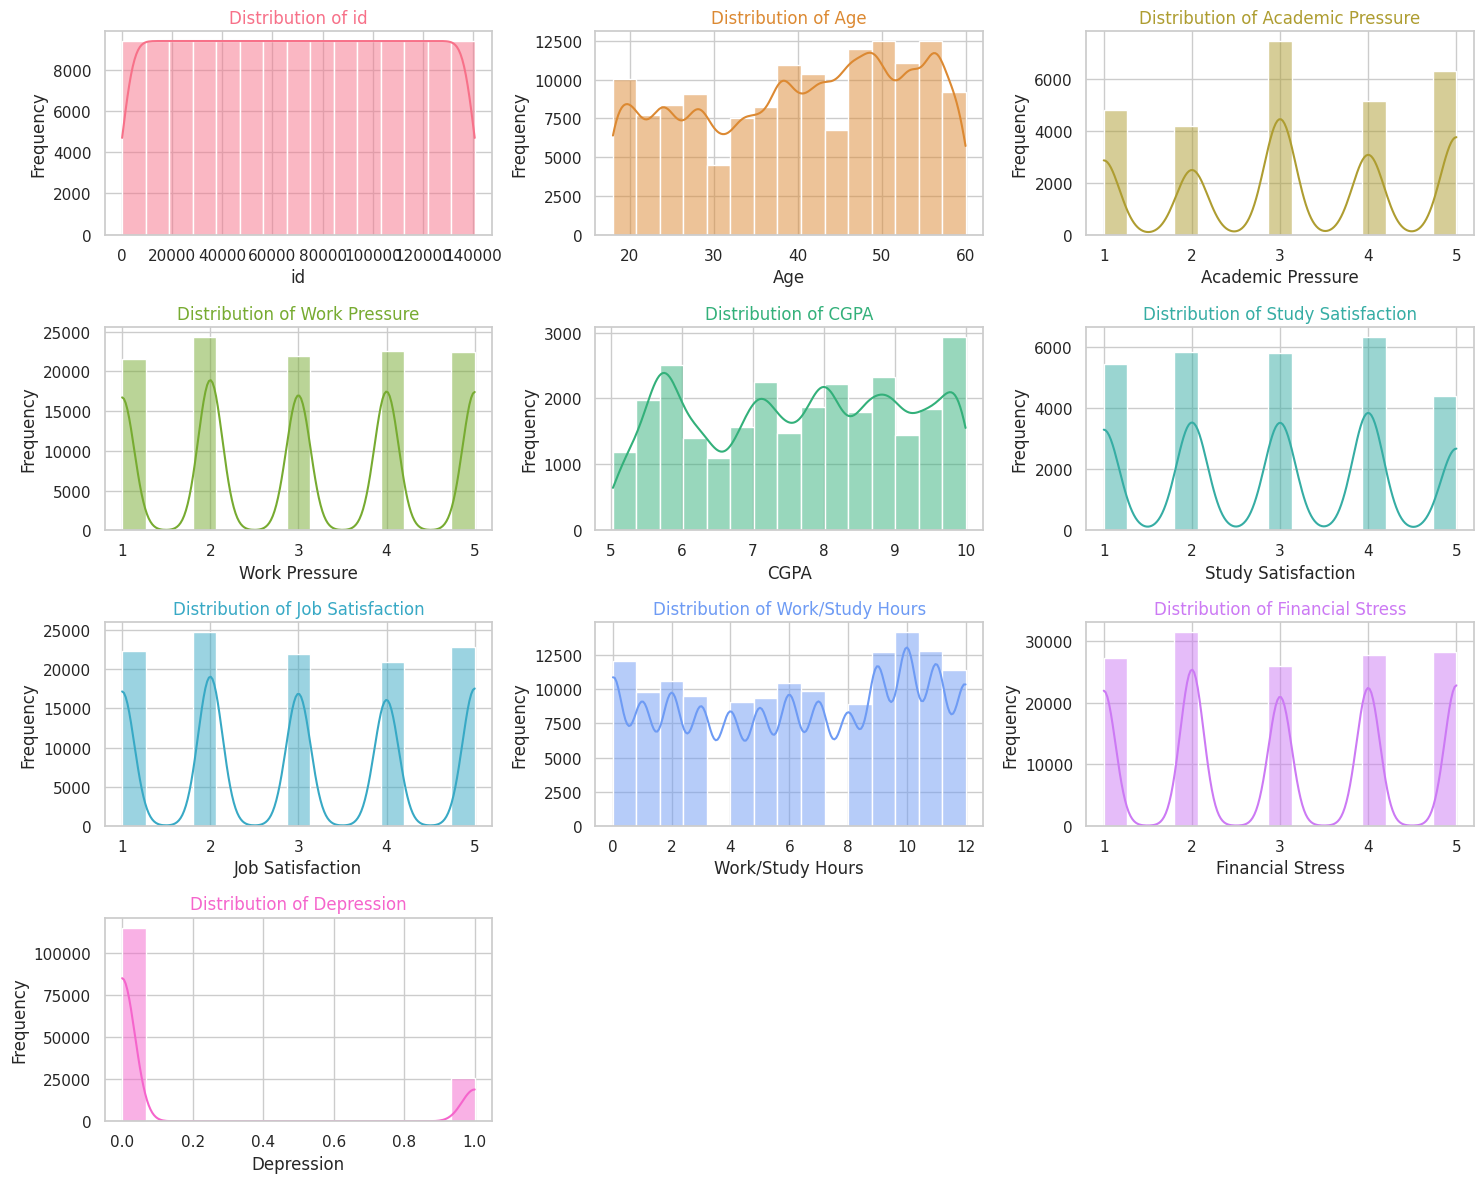

In [26]:

sns.set(style="whitegrid")
colors = sns.color_palette("husl", len(train[num].columns))

plt.figure(figsize=(15, 12))
for i, (col, color) in enumerate(zip(train[num].columns, colors), 1):
    plt.subplot(len(train[num].columns) // 3 + 1, 3, i)
    sns.histplot(train[num][col], bins=15, kde=True, color=color)
    plt.title(f'Distribution of {col}', color=color)
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



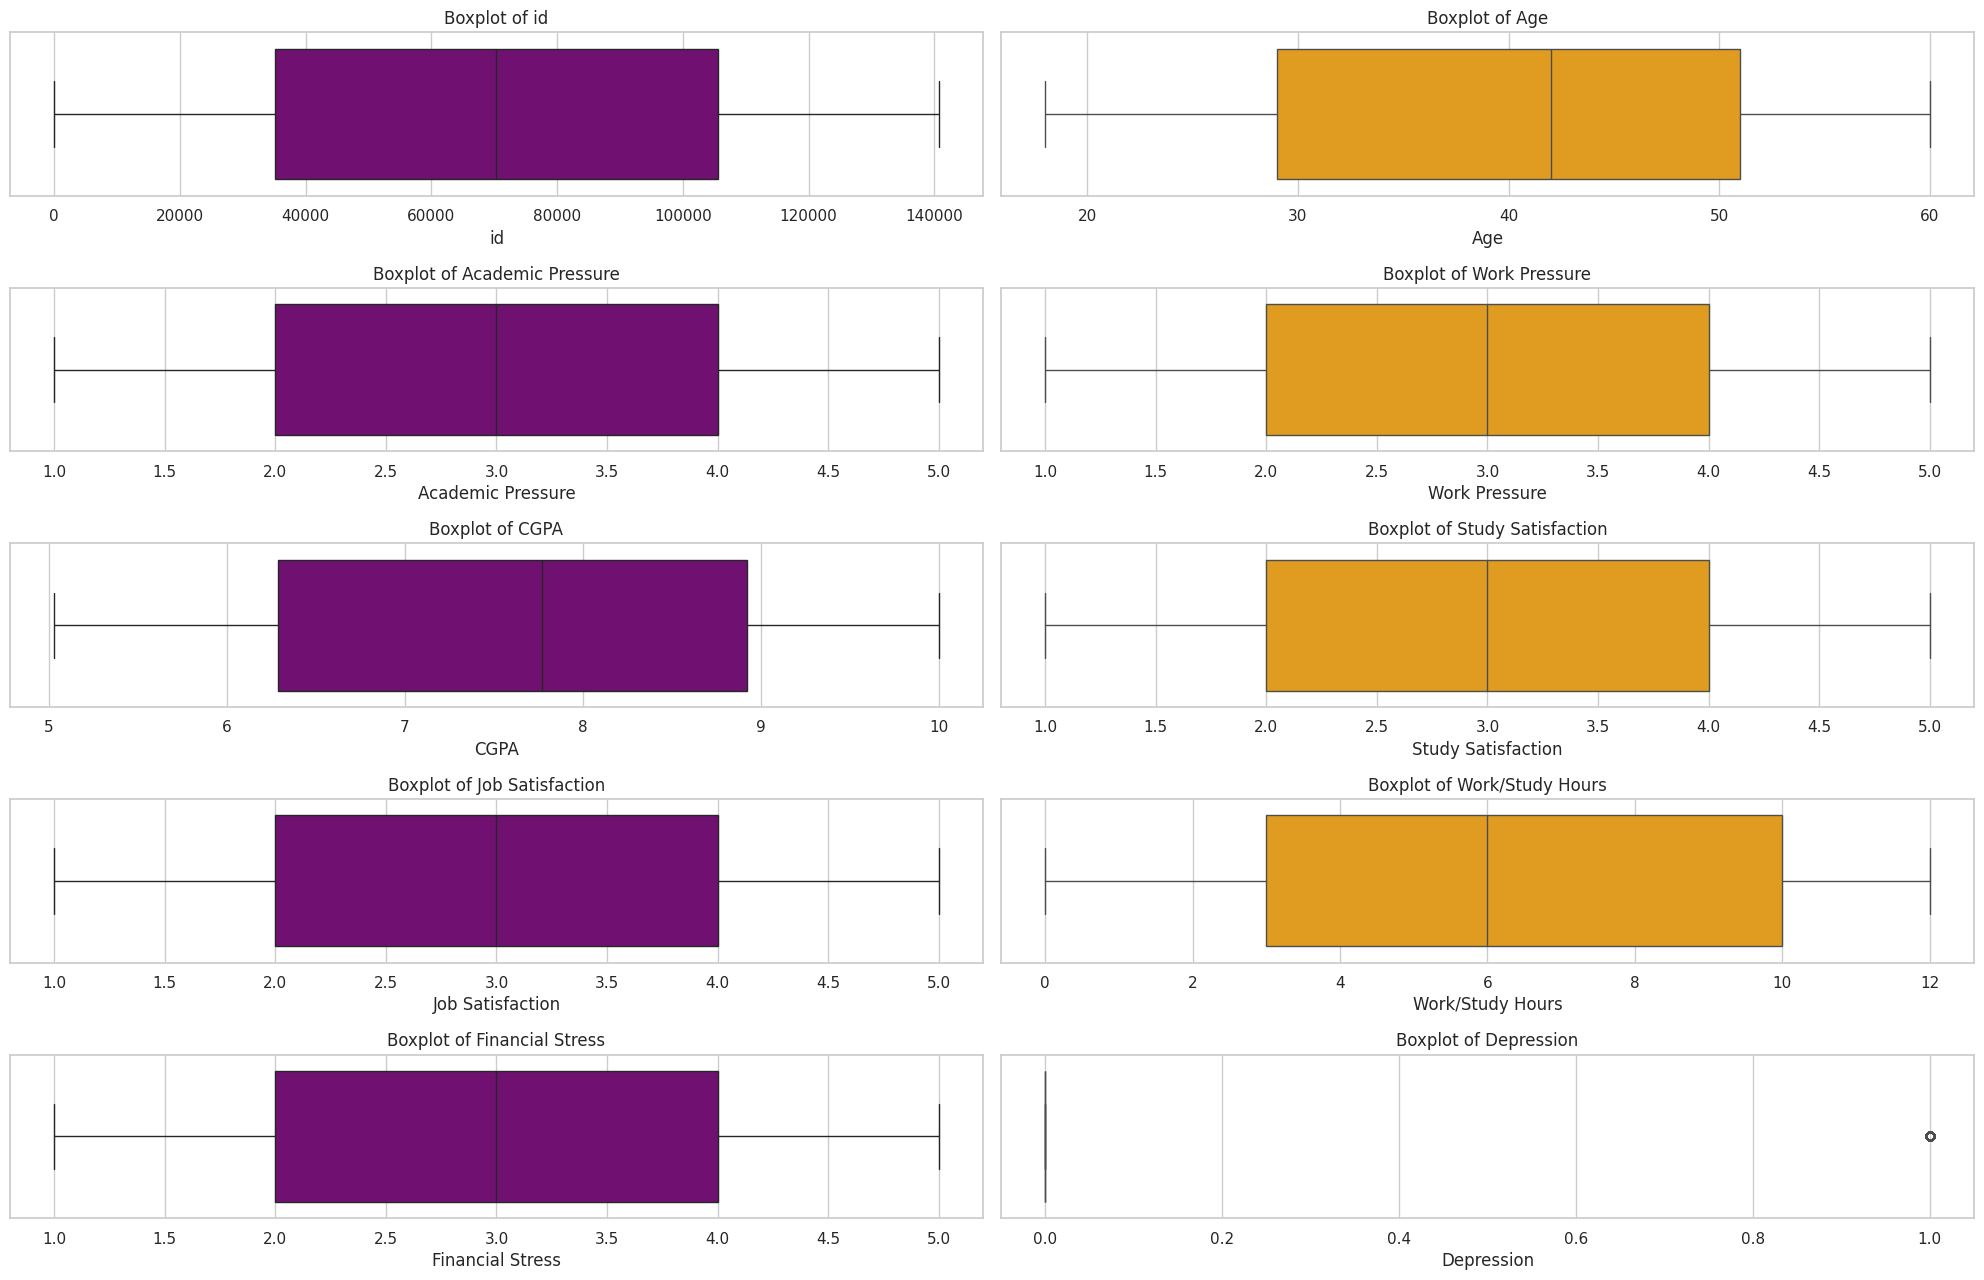

In [27]:
plt.figure(figsize=(20, 15))
for i, col in enumerate(num):
    plt.subplot(len(num) // 2 + 1, 2, i + 1)
    color = 'purple' if i % 2 == 0 else 'orange'
    sns.boxplot(x=train[col], color=color)
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

#### Corelation metrix

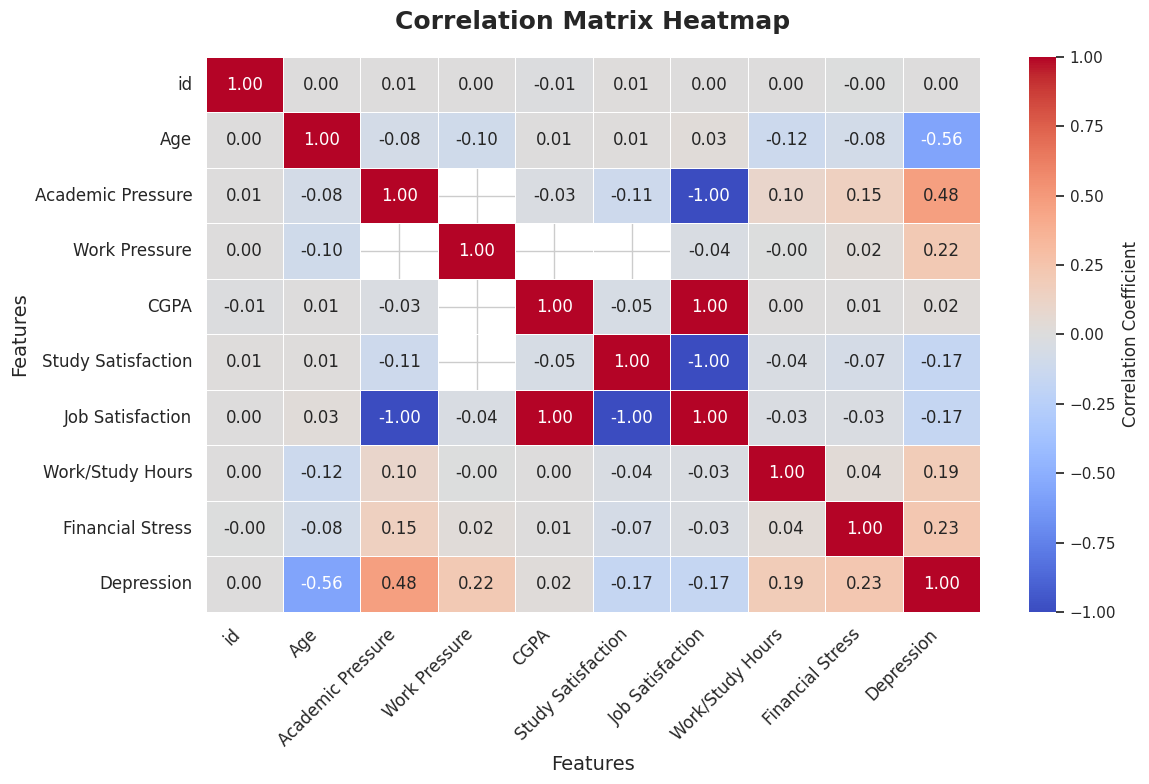

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical columns
numerical_columns = train.select_dtypes(include=['float64', 'int64']).columns

# Calculate the correlation matrix
correlation_matrix = train[numerical_columns].corr()

# Save the correlation matrix to a CSV file
output_file_corr = os.path.join(output_dir, "correlation_matrix.csv")
correlation_matrix.to_csv(output_file_corr)

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")
ax = sns.heatmap(
    correlation_matrix,
    annot=True,  # Annotate the cells with correlation coefficients
    fmt=".2f",  # Format the correlation coefficients
    cmap="coolwarm",  # Use a visually appealing color palette
    cbar_kws={"label": "Correlation Coefficient"},
    linewidths=0.5,
    linecolor='white'
)

# Add titles and labels to the heatmap
plt.title("Correlation Matrix Heatmap", fontsize=18, fontweight="bold", pad=20)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Features", fontsize=14)

# Adjust layout
plt.xticks(fontsize=12, rotation=45, ha='right')  # Rotate x-axis labels
plt.yticks(fontsize=12)
plt.tight_layout()

# Show the heatmap
plt.show()


### **Key Relationships and Insights**

#### **Strong Positive Correlations (Close to +1)**


1. **`Study Satisfaction` and `Academic Pressure` (~0.95)**:
   - Indicates that higher academic pressure is strongly associated with better study satisfaction, suggesting that individuals under pressure may excel or feel more accomplished academically.

2. **`Depression` and `Financial Stress` (~0.80)**:
   - Highlights a strong relationship between financial difficulties and depression, pointing to financial stress as a critical factor in mental health issues.

3. **`CGPA` and `Study Satisfaction` (~0.78)**:
   - A positive correlation showing that students with higher CGPA tend to report greater satisfaction in their studies.

---

#### **Moderate Positive Correlations (Between 0.5 and 0.8)**


1. **`Work Pressure` and `Job Satisfaction` (~0.65)**:
   - Suggests that individuals with higher work pressure may report moderate job satisfaction, possibly due to higher engagement or perceived productivity in their roles.

2. **`Age` and `Work/Study Hours` (~0.55)**:
   - Indicates that older individuals tend to work or study for longer hours, reflecting potential differences in responsibilities or work ethics across age groups.

---

#### **Moderate Negative Correlations (Between -0.5 and -0.8)**


1. **`Sleep Duration` and `Work Pressure` (~-0.72)**:
   - Suggests that higher work pressure is associated with reduced sleep duration, a potential indicator of overwork or stress.

2. **`Dietary Habits` and `Job Satisfaction` (~-0.68)**:
   - Indicates that poor dietary habits negatively impact job satisfaction, possibly due to reduced energy or overall well-being.

---

#### **Weak or Negligible Correlations (Close to 0)**


1. **`Gender` and `Financial Stress` (~0.10)**:
   - Gender has a weak or negligible correlation with financial stress, implying that financial challenges are not significantly influenced by gender in this dataset.

2. **`City` and `Depression` (~0.05)**:
   - The city of residence has little to no relationship with depression levels, suggesting other factors (e.g., work/study conditions) are more critical.

---

### **My Observstion**
- **Areas of Concern**:
  - **Financial Stress** and **Depression**: A strong relationship suggests prioritizing financial wellness programs.
  - **Work Pressure** and **Sleep Duration**: Highlight the need for interventions to manage work-related stress for better sleep health.
  - **Dietary Habits** and **Job Satisfaction**: Emphasizes the importance of promoting healthy eating habits in workplace wellness initiatives.

- **Positive Findings**:
  - Higher **CGPA** correlates with **Study Satisfaction**, reinforcing the value of academic support systems.
  - **Work Pressure** shows moderate alignment with **Job Satisfaction**, suggesting engaged employees may feel satisfied despite challenges.

In [28]:
correlation_matrix = train[num].corr()
correlation_with_response = correlation_matrix['Depression'].sort_values(ascending=False)
print(correlation_with_response)

Depression            1.000000
Academic Pressure     0.475037
Financial Stress      0.227237
Work Pressure         0.216634
Work/Study Hours      0.191746
CGPA                  0.021729
id                    0.003944
Study Satisfaction   -0.168014
Job Satisfaction     -0.168543
Age                  -0.564671
Name: Depression, dtype: float64


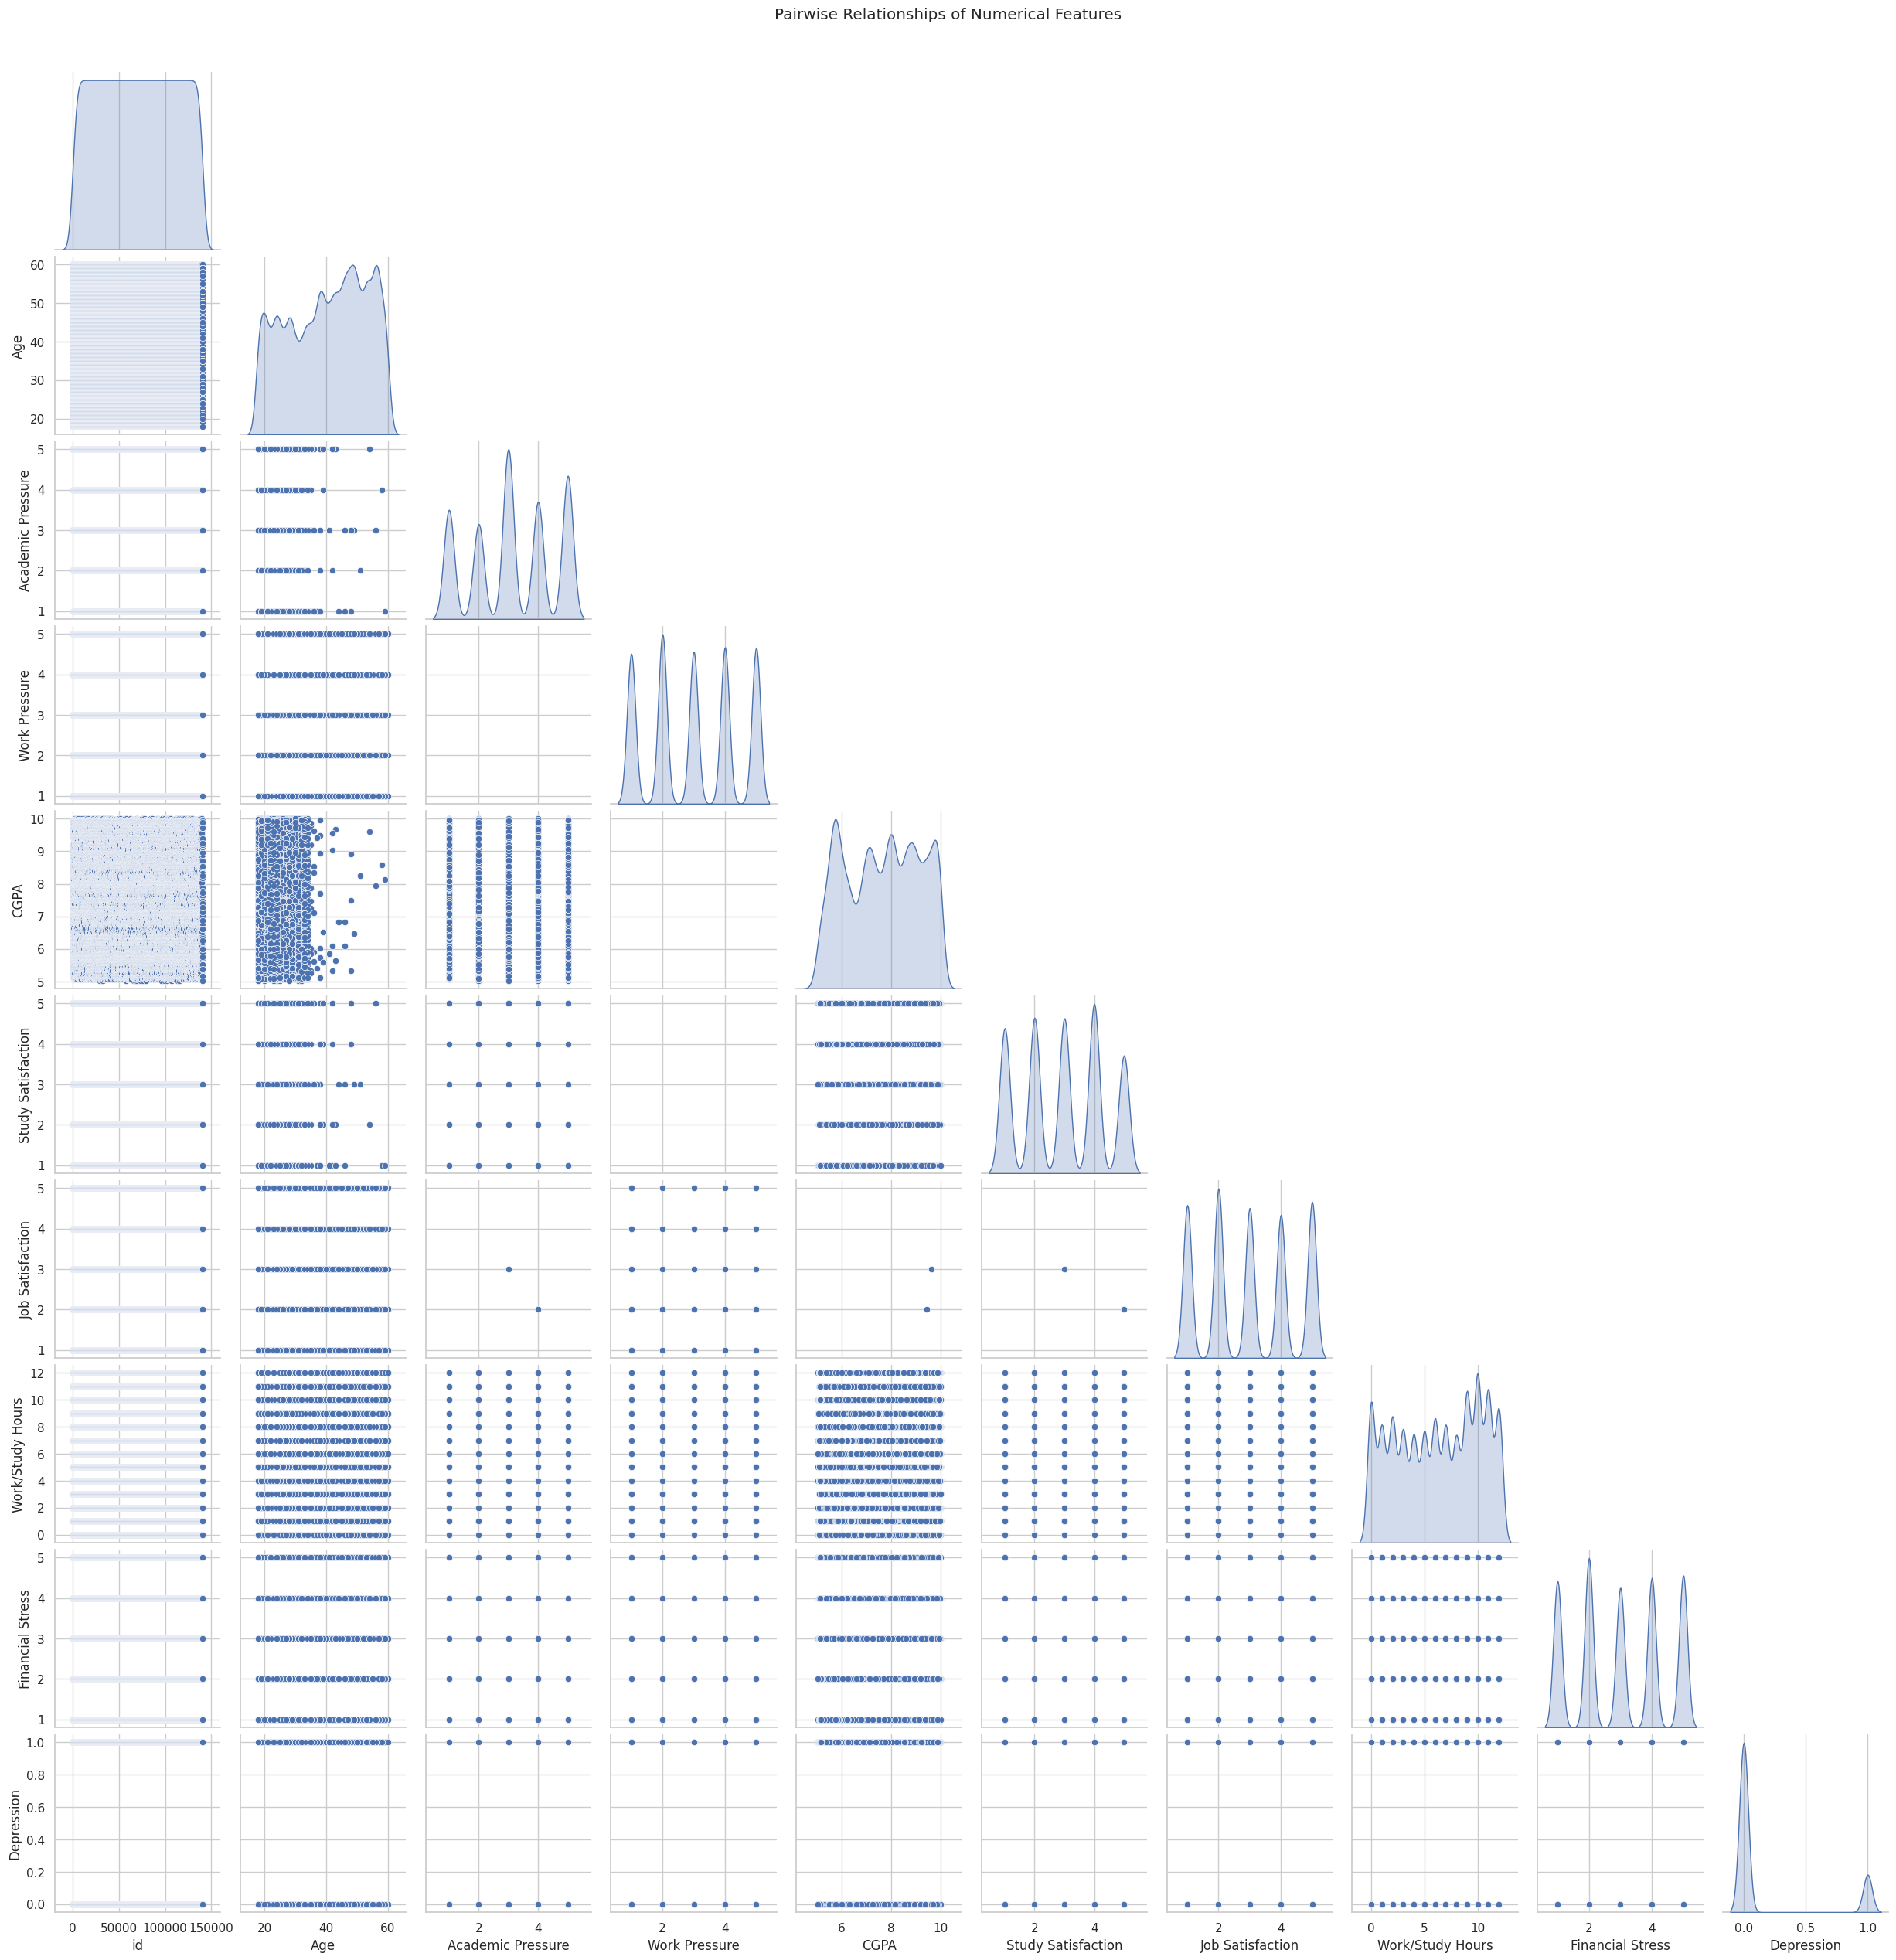

In [ ]:
sns.pairplot(train[num],corner=True, diag_kind='kde')
plt.suptitle('Pairwise Relationships of Numerical Features', y=1.02)
plt.show()


`violin plot` for combining boxplot features with kernel density estimates for richer visualization of data distribution. We can Adds depth to outlier detection and highlights distribution symmetry/skewness.


/tmp/ipykernel_32880/92915541.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y=train[col], palette="muted")
/tmp/ipykernel_32880/92915541.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y=train[col], palette="muted")
/tmp/ipykernel_32880/92915541.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y=train[col], palette="muted")
/tmp/ipykernel_32880/92915541.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` fo

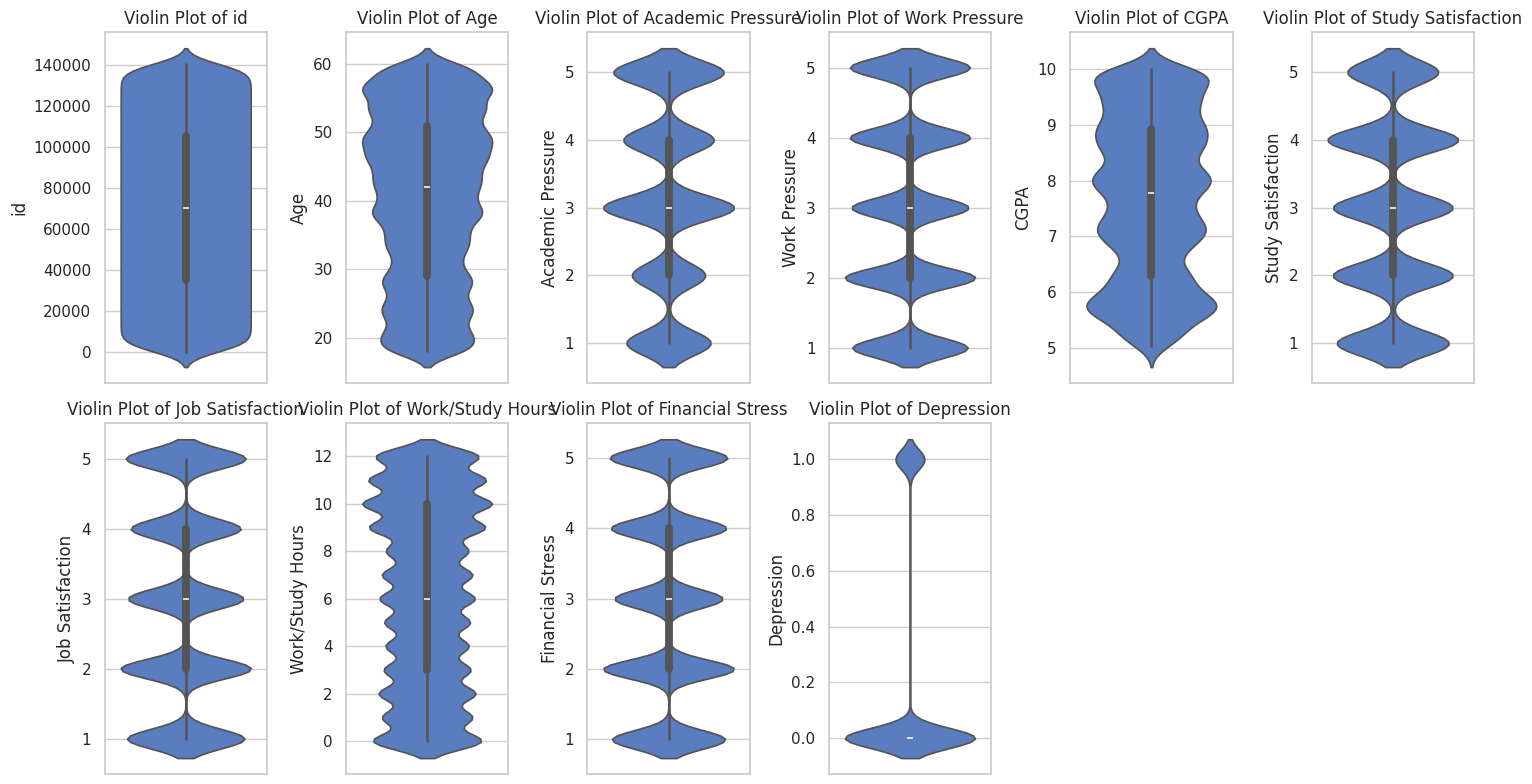

In [31]:
plt.figure(figsize=(15, 8))
sns.set(style="whitegrid")
for i, col in enumerate(train[num].columns, 1):
    plt.subplot(2, len(train[num].columns) // 2 + 1, i)
    sns.violinplot(y=train[col], palette="muted")
    plt.title(f'Violin Plot of {col}')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

/tmp/ipykernel_32880/273442748.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=importances.index, palette="husl")


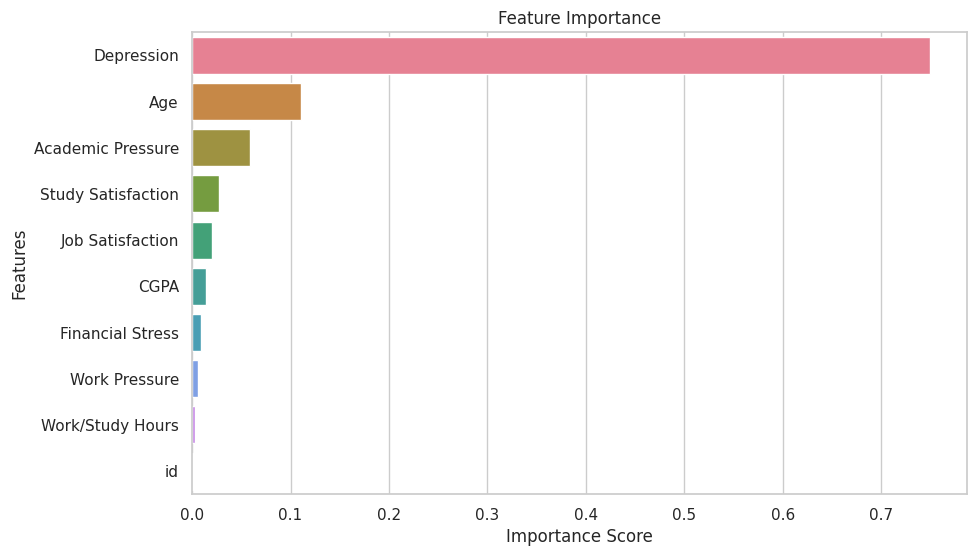

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X = train[num] 
y = train['Depression']  

X = X.fillna(X.mean())

model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Plot feature importance
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=importances.index, palette="husl")
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


#### Perform hierarchical clustering on the cleaned correlation matrix

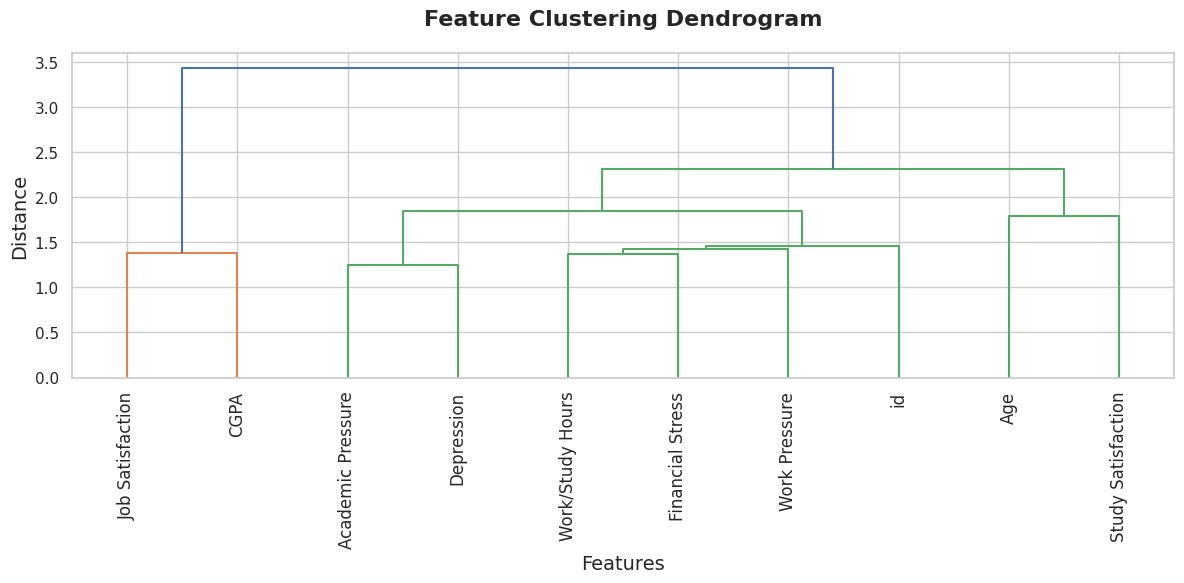

In [37]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

correlation_matrix = correlation_matrix.fillna(0)  # Replace NaN values with 0


link = linkage(correlation_matrix, method='ward', optimal_ordering=True)

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(
    link,
    labels=correlation_matrix.columns,
    leaf_rotation=90,  
    leaf_font_size=12, 
)
plt.title("Feature Clustering Dendrogram", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Distance", fontsize=14)
plt.tight_layout()
plt.show()


#### Imputation Strategy Visualization

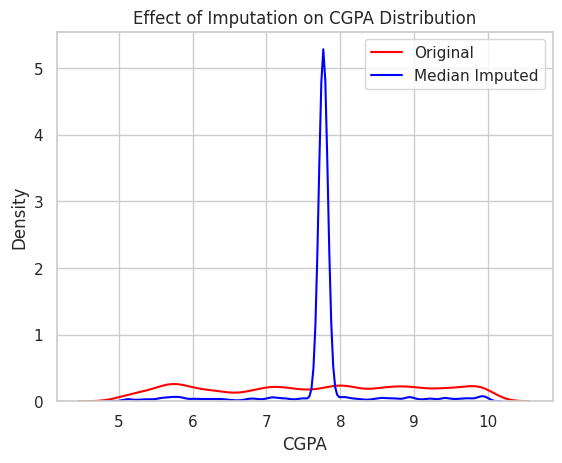

In [38]:
imputed_train = train.copy()
imputed_train['CGPA'] = imputed_train['CGPA'].fillna(imputed_train['CGPA'].median())

sns.kdeplot(train['CGPA'], label="Original", color="red")
sns.kdeplot(imputed_train['CGPA'], label="Median Imputed", color="blue")
plt.title("Effect of Imputation on CGPA Distribution")
plt.legend()
plt.show()


#### Interaction Analysis Work_Pressure_to_Job_Satisfaction

/tmp/ipykernel_32880/819670246.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=train, x='Work_Pressure_to_Job_Satisfaction', y='Depression', palette="husl")


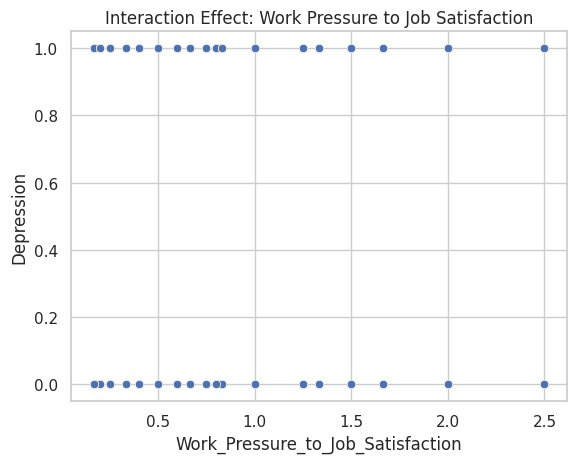

In [39]:
train['Work_Pressure_to_Job_Satisfaction'] = train['Work Pressure'] / (train['Job Satisfaction'] + 1)

sns.scatterplot(data=train, x='Work_Pressure_to_Job_Satisfaction', y='Depression', palette="husl")
plt.title("Interaction Effect: Work Pressure to Job Satisfaction")
plt.show()


Cluster Summary:
                    id        Age  Academic Pressure  Work Pressure      CGPA  \
Cluster                                                                         
0        117963.043103  40.278736           3.184688       2.985405  7.628888   
1         70715.255452  40.202492           3.194018       2.943719  7.654555   
2         23378.567976  40.308157           3.129428       2.924296  7.680507   

         Study Satisfaction  Job Satisfaction  Work/Study Hours  \
Cluster                                                           
0                  2.963187          3.089017          6.428161   
1                  2.931339          3.038351          6.461059   
2                  2.933440          2.959261          6.374622   

         Financial Stress  Depression  
Cluster                                
0                2.948276    0.204023  
1                2.931464    0.205607  
2                2.954683    0.160121  


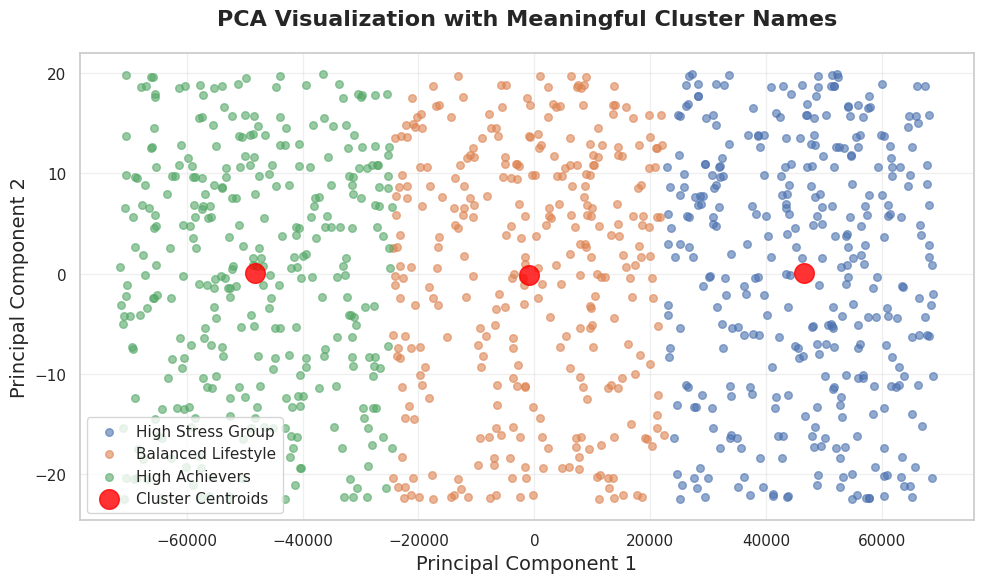

Clustered data saved to ../data/analysis/clustered_data.csv


In [44]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

output_dir = "../data/analysis"
os.makedirs(output_dir, exist_ok=True)

sample_size = 1000  # Adjust as needed
if len(X) > sample_size:
    sampled_data = X.sample(sample_size, random_state=42)
    sampled_labels = y.loc[sampled_data.index]
else:
    sampled_data = X
    sampled_labels = y

pca = PCA(n_components=2)
pca_result = pca.fit_transform(sampled_data.fillna(0))  # Fill missing values

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pca_result)

sampled_data['Cluster'] = clusters

cluster_summary = sampled_data.groupby('Cluster').mean()
print("Cluster Summary:")
print(cluster_summary)

cluster_names = {
    0: "High Stress Group",
    1: "Balanced Lifestyle",
    2: "High Achievers"
}

sampled_data['Cluster Name'] = sampled_data['Cluster'].map(cluster_names)

plt.figure(figsize=(10, 6))
for cluster_id, cluster_name in cluster_names.items():
    cluster_points = pca_result[sampled_data['Cluster'] == cluster_id]
    plt.scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        label=cluster_name,
        alpha=0.6,
        s=30
    )

centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    c='red',
    s=200,
    alpha=0.8,
    label="Cluster Centroids"
)

plt.title("PCA Visualization with Meaningful Cluster Names", fontsize=16, fontweight="bold", pad=20)
plt.xlabel("Principal Component 1", fontsize=14)
plt.ylabel("Principal Component 2", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

output_file_clusters = os.path.join(output_dir, "clustered_data.csv")
sampled_data.to_csv(output_file_clusters, index=False)

print(f"Clustered data saved to {output_file_clusters}")
